# Beamline Analyzer
### Uses G4Beamline "simple" files as input

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import uproot
import math
from glob import glob
import awkward as ak
%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
_colors = prop_cycle.by_key()['color']

In [3]:
_save_dir = 'plots/lariat_off_JGG_on/T2/'

# lariat colors
colors = [
    # 'gray', 
    (24/ 255, 33/ 255, 92/ 255),
    'gray',
    (109/ 255, 102/ 255, 146/ 255),
    (88/ 255, 130/ 255, 175/ 255),
    (129/ 255, 181/ 255, 203/ 255),
    (197/ 255, 221/ 255, 205/ 255),
]

In [4]:
# config05_2, better JGG with field
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config05_2/merged_sim_arcs_beamline_simple_9858of30k.root'
# n_pions = 9858 * 30000
# config = 'config05_2'

# config07_1, BFIELD=0
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config07_1/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
# f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
# n_pions = 9511 * 30000
# config = 'config07_1'

# config08_1, BFIELD=0, cryo and LAr
f = '/pnfs/lariat/persistent/users/gcicogna/BeamLineSimOutputs/pos60Amps/config09_1/merged_sim_arcs_beamline_simple_first5000.root'

n_pions = 5000 * 30000
config = 'config09_1'


In [5]:
file = uproot.open(f)
print('Detectors:', file.keys())

n_spills = n_pions / 2.5e5
n_hours = n_spills / 60
n_months = n_spills / 60 / 24 / 30

print('Number of pions:', n_pions)
print('Number of spills:', n_spills)
print('Number of hours:', n_hours)
print('Number of months:', n_months)


Detectors: ['VirtualDetector;1', 'VirtualDetector/Det4;1', 'VirtualDetector/Det7;1', 'VirtualDetector/DetT1;1', 'VirtualDetector/DetT2;1', 'VirtualDetector/JGGDet1;1', 'VirtualDetector/JGGDet2;1', 'VirtualDetector/JGGDet3;1']
Number of pions: 150000000
Number of spills: 600.0
Number of hours: 10.0
Number of months: 0.01388888888888889


In [6]:
print('TTree variabels:', file[f'VirtualDetector/JGGDet1'].keys())
print('Number of entries in Det4:', file[f'VirtualDetector/Det4'].num_entries)
print('Number of entries in DetT1:', file[f'VirtualDetector/DetT1'].num_entries)
print('Number of entries in DetT2:', file[f'VirtualDetector/DetT2'].num_entries)
print('Number of entries in Det7:', file[f'VirtualDetector/Det7'].num_entries)
print('Number of entries in JGGDet1:', file[f'VirtualDetector/JGGDet1'].num_entries)

TTree variabels: ['x', 'y', 'z', 'Px', 'Py', 'Pz', 't', 'PDGid', 'EventID', 'TrackID', 'ParentID', 'Weight']
Number of entries in Det4: 254388
Number of entries in DetT1: 47847990
Number of entries in DetT2: 14243322
Number of entries in Det7: 13515522
Number of entries in JGGDet1: 29372513


In [7]:
def add_vars_to_df(df):
    '''
    Adds total momentum, as well as theta and phi, to the dataframe
    '''

    px = df['Px'].values
    py = df['Py'].values
    pz = df['Pz'].values

    p = np.sqrt(px**2 + py**2 + pz**2)
    theta = np.arccos(pz / p) / np.pi * 180
    phi = np.arctan2(py, px) / np.pi * 180

    df['P'] = p
    df['theta'] = theta
    df['phi'] = phi

    return df


In [8]:
branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid', 'EventID', 'TrackID']

dfs = {} # dictionary to store dataframes, list accessible by detector name

#reading data from .root file

#dfs['DetT1'] = file[f'VirtualDetector/DetT1'].arrays(branches, library='pd')
dfs['DetT2'] = file[f'VirtualDetector/DetT2'].arrays(branches, library='pd')
dfs['Det7'] = file[f'VirtualDetector/Det7'].arrays(branches, library='pd')
dfs['JGGDet1'] = file[f'VirtualDetector/JGGDet1'].arrays(branches, library='pd')

#removing duplicates
#dfs['DetT1'] = dfs['DetT1'].drop_duplicates(['EventID', 'TrackID'])
dfs['DetT2'] = dfs['DetT2'].drop_duplicates(['EventID', 'TrackID'])
dfs['Det7'] = dfs['Det7'].drop_duplicates(['EventID', 'TrackID'])
dfs['JGGDet1'] = dfs['JGGDet1'].drop_duplicates(['EventID', 'TrackID'])

#adding total momentum, theta and phi to the dataframes
#dfs['DetT1'] = add_vars_to_df(dfs['DetT1'])
dfs['DetT2'] = add_vars_to_df(dfs['DetT2'])
dfs['Det7'] = add_vars_to_df(dfs['Det7'])
dfs['JGGDet1'] = add_vars_to_df(dfs['JGGDet1'])

# print(dfs['DetT1'])
# print(dfs['JGGDet1'])

# df2.loc[(df2['EventID'] == 29970112.0) & (df2['TrackID'] == 121664.0)]

## Merge TTrees

Merging TTrees for 4 detectors.

First merge: DetT1 and DetT2.
Second merge: (first) and Det7.
Third merge: (second) and JGGDet1.

The goal is to keep particles that are present in the 4 detectors [DetT1, DetT2, Det7, JGGDet1], to select particles to trigger on.

The detectors are on-axis with the beam; JGG is ON, LArIAT magnets are OFF.

In [9]:
#First Merge: DetT1 and DetT2 -----------------------------------------------------------------------------------------------------
#df_merged1 = dfs['DetT1'].merge(dfs['DetT2'], on=['EventID', 'TrackID'], how='left', indicator=True, suffixes=('_DetT1', '_DetT2'))

#Drop particles that are not in both detectors
#df_merged1 = df_merged1[df_merged1['_merge'] == 'both']

#Drop PDGid columns (redundant)
#df_merged1 = df_merged1.drop(['PDGid_DetT1'], axis=1)

#Rename PDGid column
#df_merged1 = df_merged1.rename(columns={'PDGid_DetT2': 'PDGid'})

#Second Merge: DetT1+DetT2 (df_merged1) and Det7 -----------------------------------------------------------------------------------------------------
df_merged2 = dfs['DetT2'].merge(dfs['Det7'], on=['EventID', 'TrackID'], how='left', indicator='_merge1', suffixes=('_DetT2', '_Det7'))
df_merged2 = df_merged2[df_merged2['_merge1'] == 'both']
df_merged2 = df_merged2.drop(['PDGid_Det7'], axis=1)

#Third Merge: DetT1+DetT2+Det7 (df_merged2) and JGGDet1 -----------------------------------------------------------------------------------------------------
df = df_merged2.merge(dfs['JGGDet1'], on=['EventID', 'TrackID'], how='left', indicator='_merge_final', suffixes=('_merge1', '_JGGDet1'))
df = df[df['_merge_final'] == 'both']
df = df.drop(['PDGid_JGGDet1'], axis=1, errors='ignore')

df = df.rename(columns={'x':'x_JGGDet1',
                        'y':'y_JGGDet1',
                        'z':'z_JGGDet1',
                        'Px':'Px_JGGDet1', 
                        'Py':'Py_JGGDet1', 
                        'Pz':'Pz_JGGDet1', 
                        'P':'P_JGGDet1', 
                        'theta':'theta_JGGDet1', 
                        'phi':'phi_JGGDet1'})

print(df.columns)


Index(['x_DetT2', 'y_DetT2', 'z_DetT2', 'Px_DetT2', 'Py_DetT2', 'Pz_DetT2',
       'PDGid_DetT2', 'EventID', 'TrackID', 'P_DetT2', 'theta_DetT2',
       'phi_DetT2', 'x_Det7', 'y_Det7', 'z_Det7', 'Px_Det7', 'Py_Det7',
       'Pz_Det7', 'P_Det7', 'theta_Det7', 'phi_Det7', '_merge1', 'x_JGGDet1',
       'y_JGGDet1', 'z_JGGDet1', 'Px_JGGDet1', 'Py_JGGDet1', 'Pz_JGGDet1',
       'PDGid', 'P_JGGDet1', 'theta_JGGDet1', 'phi_JGGDet1', '_merge_final'],
      dtype='object')


In [10]:
# df.query('PDGid==11 and P_Det7 < 100 and theta_Det7 < 10')

In [11]:
def get_values_labels(df, det='JGGDet1', variable='p', p_cut=80):
    '''
    Returns values to plot with their labels

    Args:
        det (str): the detector to plot
        variable (str): the variable to plot
        p_cut (int): momentum cut
    '''

    # Apply a momentum cut
    df_ = df.query(f'P_{det} > {p_cut}')

    # if det == 'Det7':
    #     df_ = df_.query(f'theta_{det} < 1')

    pdg = df_['PDGid'].values

    if variable == 'p':
        var = df_[f'P_{det}'].values
    elif variable == 'theta':
        var = df_[f'theta_{det}'].values
    elif variable == 'phi':
        var = df_[f'phi_{det}'].values
        
    kaons = var[np.abs(pdg)==321]
    positrons = var[pdg==-11]
    electrons = var[pdg==+11]
    muons = var[np.abs(pdg)==13]
    protons = var[np.abs(pdg)==2212]
    pions = var[np.abs(pdg)==211]
    others = var[ (np.abs(pdg)!=321) & (np.abs(pdg)!=11) & (np.abs(pdg)!=13) & (np.abs(pdg)!=2212) & (np.abs(pdg)!=211)]
    gamma = var[np.abs(pdg)==22]
    
    values = [
        # others,
        # gamma,
        kaons,
        positrons,
        electrons,
        muons,
        protons,
        pions,
    ]

    tot = len(kaons) + len(electrons) + len(positrons) + len(muons) + len(protons) + len(pions)
    # tot += len(others)
    # tot += len(gamma)
    
    labels = [
        # 'others' + f', ({len(others) / tot * 100:.1f}%)',
        # 'gamma' + f', ({len(gamma) / tot * 100:.1f}%)',
        r'$K^\pm$' + f', ({len(kaons):.2e}, {len(kaons) / tot * 100:.1f}%)',
        r'$e^+$' + f', ({len(positrons):.2e}, {len(positrons) / tot * 100:.1f}%)',
        r'$e^-$' + f', ({len(electrons):.2e}, {len(electrons) / tot * 100:.1f}%)',
        r'$\mu^\pm$' + f', ({len(muons):.2e}, {len(muons) / tot * 100:.1f}%)',
        r'$p^\pm$' + f', ({len(protons):.2e}, {len(protons) / tot * 100:.1f}%)',
        r'$\pi^\pm$' + f', ({len(pions):.2e}, {len(pions) / tot * 100:.1f}%)'
    ]

    return values, labels

FileNotFoundError: [Errno 2] No such file or directory: '/exp/lariat/app/users/gcicogna/beamline/Analysis/plots/laria_off_JGG_on/T2/spectra_g4blsimpleT_df_config09_1_detDetT2.jpg'

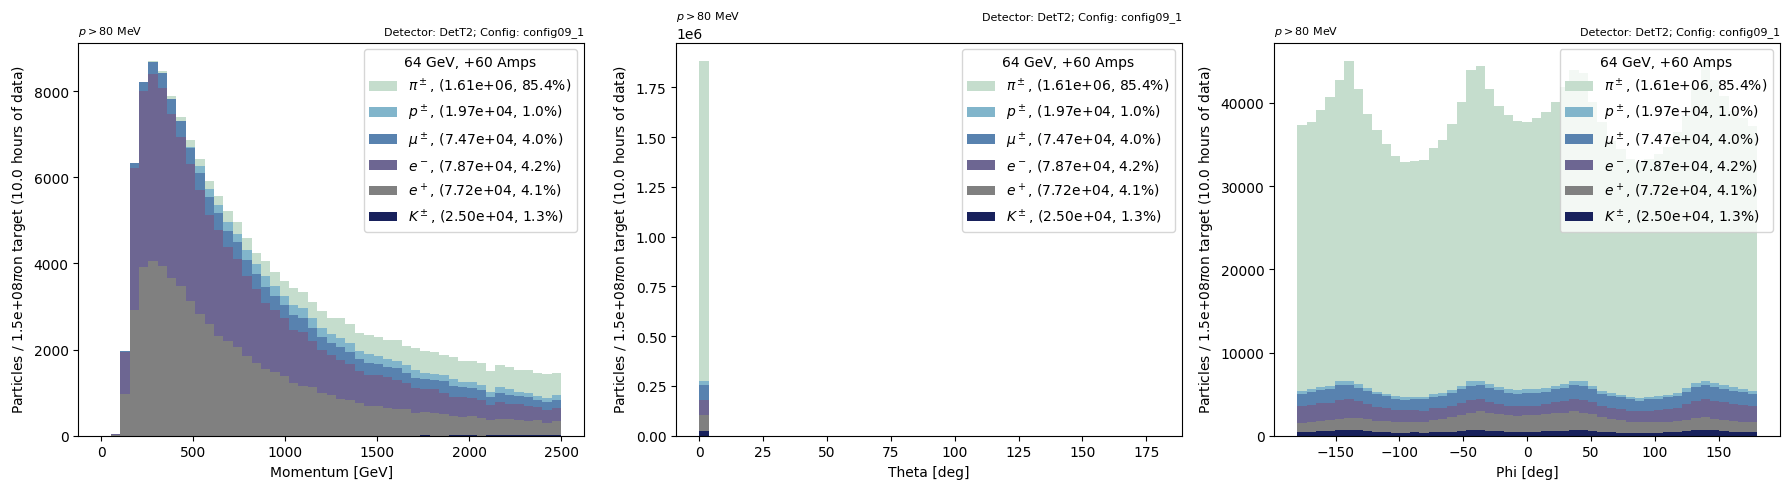

In [12]:
for det in ['DetT2', 'Det7', 'JGGDet1']:

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [GeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    for i, variable in enumerate(['p', 'theta', 'phi']):

        p_cut = 80

        values, labels = get_values_labels(df, det, variable, p_cut)
    
        bins = x_bins[variable]
        if det == 'Det4' and i == 0:
            bins = np.linspace(200, 1600, 30)
        if det == 'Det5' and i == 0:
            bins = np.linspace(150, 2500, 50)
        
        ax[i].hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax[i].legend()
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)
    
        ax[i].set_xlabel(x_axis[variable])
        ax[i].set_ylabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)' )
        ax[i].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
        ax[i].set_title(f'$p>{p_cut}$ MeV', loc='left', fontsize=8)
        
        # if det == 'Det7' or det == 'Det8' or 'JGG' in det:
        #     ax[i].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimpleT_df_{config}_det{det}.jpg')
    plt.show()


In [ ]:
for det in ['DetT2', 'Det7', 'JGGDet1']:

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [GeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    xbins = np.linspace(-235-60, 235+60, 50)
    ybins = np.linspace(-200-60, 200+60, 50)
    if det == 'Det4':
        xbins = np.linspace(-64-1195.0827-10, 64-1195.0827+10, 50)
        ybins = np.linspace(-62.5-20.4724-10, 62.5-20.4724+10, 50)
    ax[0].hist2d(df[f'x_{det}'].values, df[f'y_{det}'].values, bins=[xbins, ybins])
    ax[0].set_xlabel('X [mm]')
    ax[0].set_ylabel('Y [mm]')
    ax[0].set_title(f'Detector: {det}', loc='right', fontsize=8)

    # mask_e = np.abs(pdg) == 11
    ax[1].hist2d(df.query('abs(PDGid)==11')[f'x_{det}'], df.query('abs(PDGid)==11')[f'y_{det}'], bins=[xbins, ybins])
    ax[1].set_xlabel('X [mm]')
    ax[1].set_ylabel('Y [mm]')
    ax[1].set_title(f'Detector: {det} - Electrons Only', loc='right', fontsize=8)

    # mask_p = particle.p > 200
    ax[2].hist2d(df.query('abs(PDGid)==11 and Pz_JGGDet1 > 100')[f'x_{det}'], df.query('abs(PDGid)==11 and Pz_JGGDet1 > 100')[f'y_{det}'], bins=[xbins, ybins])
    ax[2].set_xlabel('X [mm]')
    ax[2].set_ylabel('Y [mm]')
    ax[2].set_title(f'Detector: {det} - Electrons Only, p > 100 MeV', loc='right', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimpleT_df_pos_{config}_det{det}.jpg')
    plt.show()


In [ ]:

for det in ['DetT2', 'Det7', 'JGGDet1']:

    values, labels = get_values_labels(df, det, 'p', 80)

    #creating a single figure for PID
    fig, ax = plt.subplots(figsize=(10,6))

    #occurences for each PID
    counts = [len(v) for v in values]

    # create bar plot with particle counts and their types
    ax.barh(labels, counts, color=colors)

    #set labels and title 
    ax.set_xlabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)')
    ax.set_ylabel('Particle Type')
    ax.set_title(f'PID Occurences in {det} with $p > {p_cut}$ MeV [Config: {config}]', loc='right', fontsize=8)

    #add counts to the bars 
    for i, count in enumerate(counts):
        ax.text(count + 3, i, str(count), color='black', va='center')

    plt.tight_layout()
    plt.savefig(_save_dir + f'pid_g4blsimpleT_df_{config}_det{det}.jpg')
    plt.show()
    